# Evaluation and Analysis - Submission

# Checklist

4 or more performance metrics 
- Accuracy
- F1 Score
- Precision
- Recall

3 or more visualization techniques (1/3 - need 2 more)
- Confusion Matrices

## Setup and Imports

In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("✓ Libraries imported successfully!")
print(f"✓ Random seed set to: 42")

✓ Libraries imported successfully!
✓ Random seed set to: 42


## Load and Preprocess Data

Reproduce the exact same preprocessing and test split as in `all_models.ipynb`.

In [3]:
# Load the preprocessed dataset with NLP embeddings
df = pd.read_csv('data/processed/games_preprocessed.csv')

print(f"Dataset shape: {df.shape}")
print(f"Total samples: {df.shape[0]:,}")

# Convert string embeddings to numeric arrays
if 'About the game' in df.columns:
    print("\nConverting 'About the game' embeddings...")
    df['About the game'] = df['About the game'].apply(
        lambda s: np.fromstring(s.strip('[]'), sep=' ') if isinstance(s, str) else s
    )
    
    # Expand embeddings into separate columns
    embeddings_list = df['About the game'].tolist()
    embeddings_df = pd.DataFrame(embeddings_list, 
                                  columns=[f'embedding_{i}' for i in range(len(embeddings_list[0]))])
    df = df.drop('About the game', axis=1)
    df = pd.concat([embeddings_df, df], axis=1)
    print(f"✓ Expanded embeddings into {len(embeddings_list[0])} columns")

# Separate features and target
X = df.drop('popularity_class', axis=1)
y = df['popularity_class']

# Encode target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(f"\n✓ Target encoded: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Drop non-numeric columns
object_cols = X.select_dtypes(include=['object']).columns.tolist()
if object_cols:
    X = X.drop(columns=object_cols)
    print(f"✓ Dropped {len(object_cols)} non-numeric columns")

print(f"\n✓ Final feature set shape: {X.shape}")

Dataset shape: (89302, 109)
Total samples: 89,302

Converting 'About the game' embeddings...
✓ Expanded embeddings into 384 columns

✓ Target encoded: {'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}

✓ Final feature set shape: (89302, 491)
✓ Expanded embeddings into 384 columns

✓ Target encoded: {'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}

✓ Final feature set shape: (89302, 491)


### Create Test Splits

Reproduce the exact same train/test splits using the same random seed.

In [4]:
# Split 1: Full feature set (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Full Feature Split:")
print(f"  Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"  Testing set: {X_test.shape[0]} samples")

# Split 2: Reduced feature set (SelectKBest with 20 features)
X_new = SelectKBest(f_classif, k=20).fit_transform(X, y)
X_NewTrain, X_NewTest, y_NewTrain, y_NewTest = train_test_split(
    X_new, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\nReduced Feature Split (SelectKBest):")
print(f"  Training set: {X_NewTrain.shape[0]} samples, {X_NewTrain.shape[1]} features")
print(f"  Testing set: {X_NewTest.shape[0]} samples")

print(f"\n✓ Test splits created successfully!")

Full Feature Split:
  Training set: 71441 samples, 491 features
  Testing set: 17861 samples

Reduced Feature Split (SelectKBest):
  Training set: 71441 samples, 20 features
  Testing set: 17861 samples

✓ Test splits created successfully!

Reduced Feature Split (SelectKBest):
  Training set: 71441 samples, 20 features
  Testing set: 17861 samples

✓ Test splits created successfully!


## Load Trained Models

Load all 8 pre-trained models from the `.sav` files.

In [5]:
# Define model files and names
model_info = {
    'RF_Full': {'file': 'finalized_model_M1-1.sav', 'test_data': (X_test, y_test)},
    'RF_Reduced': {'file': 'finalized_model_M1-2.sav', 'test_data': (X_NewTest, y_NewTest)},
    'LR_Full': {'file': 'finalized_model_M2-1.sav', 'test_data': (X_test, y_test)},
    'LR_Reduced': {'file': 'finalized_model_M2-2.sav', 'test_data': (X_NewTest, y_NewTest)},
    'XGB_Full': {'file': 'finalized_model_M3-1.sav', 'test_data': (X_test, y_test)},
    'XGB_Reduced': {'file': 'finalized_model_M3-2.sav', 'test_data': (X_NewTest, y_NewTest)},
    'SVM_Full': {'file': 'finalized_model_M4-1.sav', 'test_data': (X_test, y_test)},
    'SVM_Reduced': {'file': 'finalized_model_M4-2.sav', 'test_data': (X_NewTest, y_NewTest)}
}

# Load all models
models = {}
for name, info in model_info.items():
    try:
        models[name] = pickle.load(open(info['file'], 'rb'))
        print(f"✓ Loaded {name}")
    except FileNotFoundError:
        print(f"✗ Could not find {info['file']}")

print(f"\n✓ Successfully loaded {len(models)}/8 models")

✓ Loaded RF_Full
✓ Loaded RF_Reduced
✓ Loaded LR_Full
✓ Loaded LR_Reduced
✓ Loaded XGB_Full
✓ Loaded XGB_Full
✓ Loaded XGB_Reduced
✓ Loaded SVM_Full
✓ Loaded SVM_Reduced

✓ Successfully loaded 8/8 models
✓ Loaded XGB_Reduced
✓ Loaded SVM_Full
✓ Loaded SVM_Reduced

✓ Successfully loaded 8/8 models


## Performance Metric 1: Accuracy

Accuracy measures the overall correctness of predictions across all classes.

In [6]:
# Calculate accuracy for each model
accuracy_results = []

for name, model in models.items():
    X_test_data, y_test_data = model_info[name]['test_data']
    y_pred = model.predict(X_test_data)
    accuracy = accuracy_score(y_test_data, y_pred)
    
    accuracy_results.append({
        'Model': name,
        'Accuracy': accuracy
    })

accuracy_df = pd.DataFrame(accuracy_results).sort_values('Accuracy', ascending=False)
print("Accuracy Scores:")
print("="*50)
print(accuracy_df.to_string(index=False))
print("="*50)

Accuracy Scores:
      Model  Accuracy
   XGB_Full  0.905492
XGB_Reduced  0.899558
    LR_Full  0.889480
    RF_Full  0.879514
   SVM_Full  0.878226
SVM_Reduced  0.878226
 RF_Reduced  0.825206
 LR_Reduced  0.759476


## Performance Metric 2: F1 Score

F1 Score is the harmonic mean of precision and recall, providing a balanced measure.

In [7]:
# Calculate F1 score for each model
f1_results = []

for name, model in models.items():
    X_test_data, y_test_data = model_info[name]['test_data']
    y_pred = model.predict(X_test_data)
    f1 = f1_score(y_test_data, y_pred, average='weighted')
    
    f1_results.append({
        'Model': name,
        'F1 Score': f1
    })

f1_df = pd.DataFrame(f1_results).sort_values('F1 Score', ascending=False)
print("F1 Scores:")
print("="*50)
print(f1_df.to_string(index=False))
print("="*50)

F1 Scores:
      Model  F1 Score
   XGB_Full  0.891520
XGB_Reduced  0.883833
    LR_Full  0.869826
 RF_Reduced  0.842227
    RF_Full  0.825586
   SVM_Full  0.821287
SVM_Reduced  0.821287
 LR_Reduced  0.801551


## Performance Metric 3: Precision

Precision measures the accuracy of positive predictions (how many predicted positives are actually positive).

In [8]:
# Calculate precision for each model
precision_results = []

for name, model in models.items():
    X_test_data, y_test_data = model_info[name]['test_data']
    y_pred = model.predict(X_test_data)
    precision = precision_score(y_test_data, y_pred, average='weighted', zero_division=0)
    
    precision_results.append({
        'Model': name,
        'Precision': precision
    })

precision_df = pd.DataFrame(precision_results).sort_values('Precision', ascending=False)
print("Precision Scores:")
print("="*50)
print(precision_df.to_string(index=False))
print("="*50)

Precision Scores:
      Model  Precision
   XGB_Full   0.889226
XGB_Reduced   0.879775
 LR_Reduced   0.867531
 RF_Reduced   0.865465
    LR_Full   0.864272
    RF_Full   0.841956
   SVM_Full   0.771281
SVM_Reduced   0.771281


## Performance Metric 4: Recall

Recall measures the ability to find all positive instances (how many actual positives are correctly identified).

In [9]:
# Calculate recall for each model
recall_results = []

for name, model in models.items():
    X_test_data, y_test_data = model_info[name]['test_data']
    y_pred = model.predict(X_test_data)
    recall = recall_score(y_test_data, y_pred, average='weighted', zero_division=0)
    
    recall_results.append({
        'Model': name,
        'Recall': recall
    })

recall_df = pd.DataFrame(recall_results).sort_values('Recall', ascending=False)
print("Recall Scores:")
print("="*50)
print(recall_df.to_string(index=False))
print("="*50)

Recall Scores:
      Model   Recall
   XGB_Full 0.905492
XGB_Reduced 0.899558
    LR_Full 0.889480
    RF_Full 0.879514
   SVM_Full 0.878226
SVM_Reduced 0.878226
 RF_Reduced 0.825206
 LR_Reduced 0.759476


## Summary: All Performance Metrics

Combined view of all metrics for easy comparison.

In [10]:
# Combine all metrics into one DataFrame
results_df = accuracy_df.copy()
results_df['F1 Score'] = results_df['Model'].map(f1_df.set_index('Model')['F1 Score'])
results_df['Precision'] = results_df['Model'].map(precision_df.set_index('Model')['Precision'])
results_df['Recall'] = results_df['Model'].map(recall_df.set_index('Model')['Recall'])

print("All Performance Metrics:")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

All Performance Metrics:
      Model  Accuracy  F1 Score  Precision   Recall
   XGB_Full  0.905492  0.891520   0.889226 0.905492
XGB_Reduced  0.899558  0.883833   0.879775 0.899558
    LR_Full  0.889480  0.869826   0.864272 0.889480
    RF_Full  0.879514  0.825586   0.841956 0.879514
   SVM_Full  0.878226  0.821287   0.771281 0.878226
SVM_Reduced  0.878226  0.821287   0.771281 0.878226
 RF_Reduced  0.825206  0.842227   0.865465 0.825206
 LR_Reduced  0.759476  0.801551   0.867531 0.759476


## Confusion Matrices

Visualize confusion matrices for reduced feature models to understand classification patterns.


RF_Reduced
Accuracy: 0.8252
F1 Score: 0.8422
Confusion matrix, without normalization
[[  156    76   156]
 [  200 13733  1753]
 [  187   750   850]]
Normalized confusion matrix
[[0.40206186 0.19587629 0.40206186]
 [0.01275022 0.87549407 0.11175571]
 [0.10464466 0.41969782 0.47565753]]


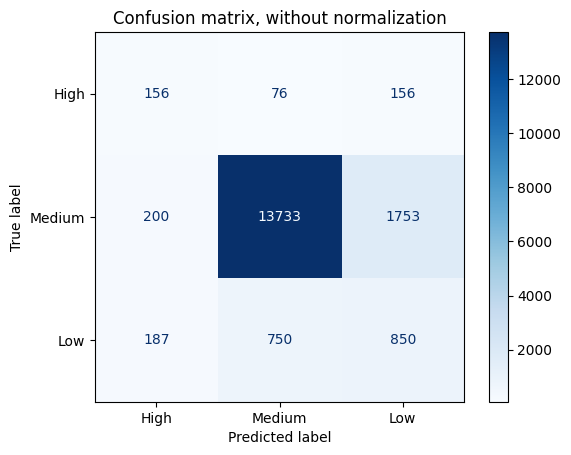

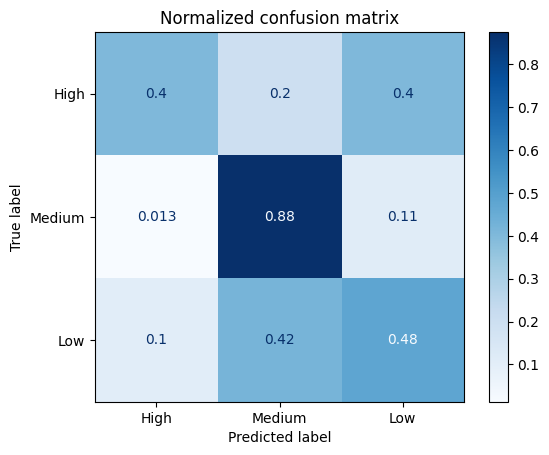


LR_Reduced
Accuracy: 0.7595
F1 Score: 0.8016
Confusion matrix, without normalization
[[  270    46    72]
 [  906 12552  2228]
 [  513   531   743]]
Normalized confusion matrix
[[0.69587629 0.1185567  0.18556701]
 [0.05775851 0.800204   0.14203749]
 [0.28707331 0.29714605 0.41578064]]


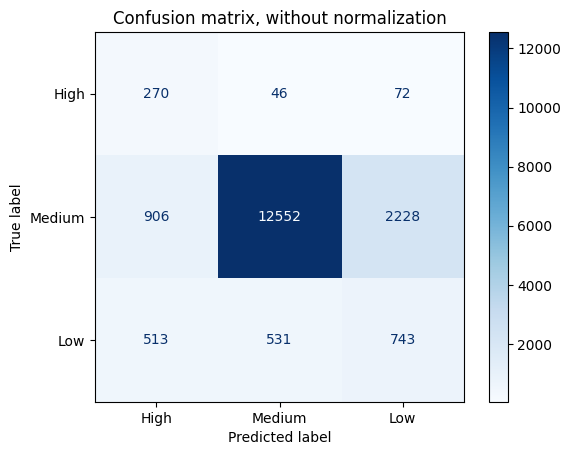

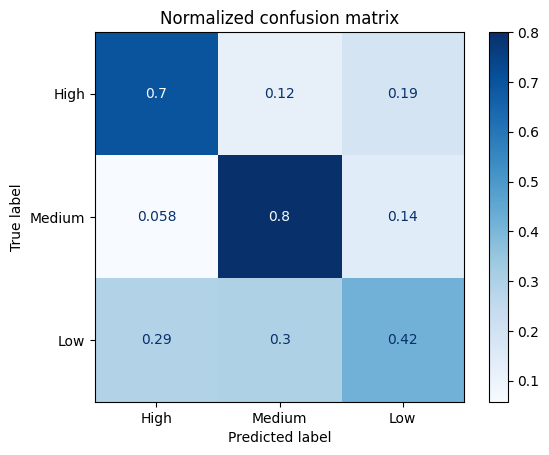


XGB_Reduced
Accuracy: 0.8996
F1 Score: 0.8838
Confusion matrix, without normalization
[[  131   103   154]
 [   20 15402   264]
 [   54  1199   534]]
Normalized confusion matrix
[[0.33762887 0.26546392 0.39690722]
 [0.00127502 0.98189468 0.01683029]
 [0.03021824 0.67095691 0.29882485]]
Normalized confusion matrix
[[0.33762887 0.26546392 0.39690722]
 [0.00127502 0.98189468 0.01683029]
 [0.03021824 0.67095691 0.29882485]]


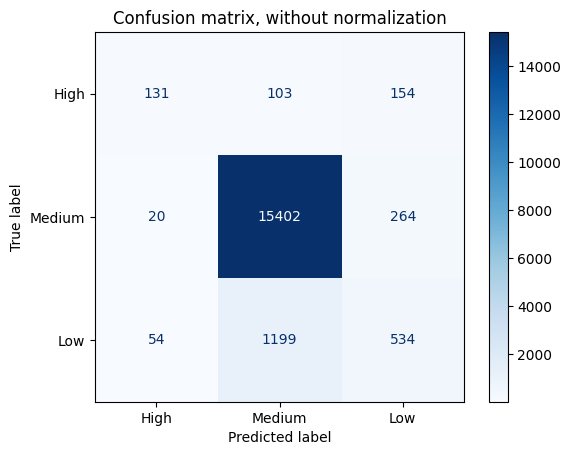

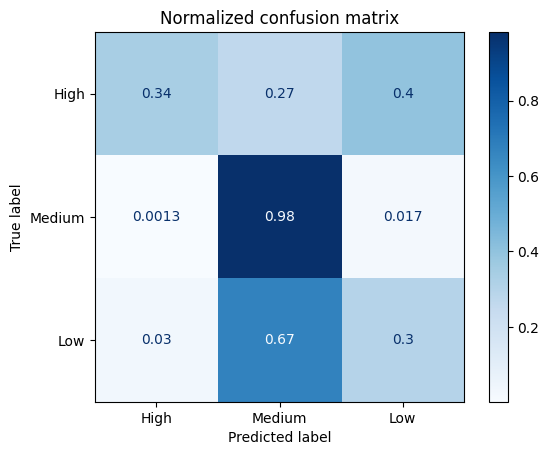


SVM_Reduced
Accuracy: 0.8782
F1 Score: 0.8213
Confusion matrix, without normalization
[[    0   388     0]
 [    0 15686     0]
 [    0  1787     0]]
Confusion matrix, without normalization
[[    0   388     0]
 [    0 15686     0]
 [    0  1787     0]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


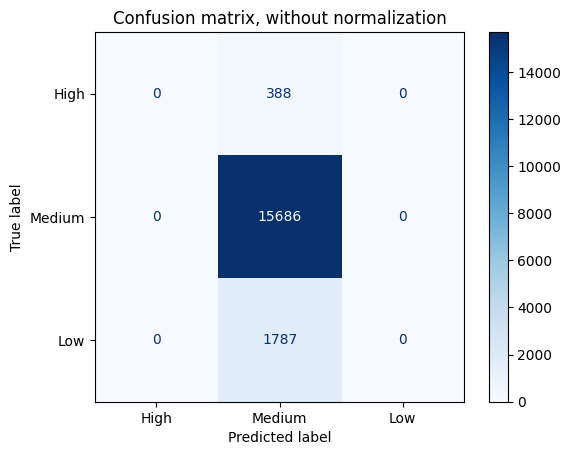

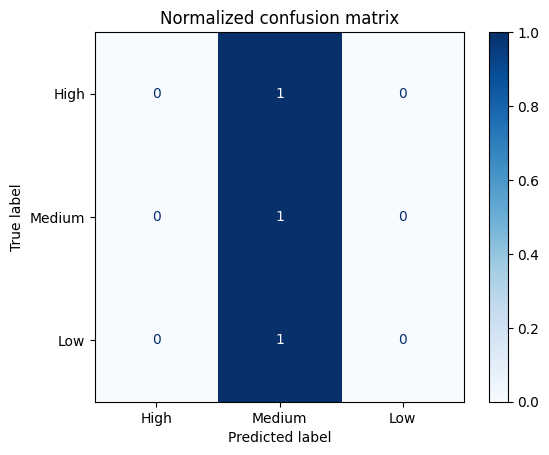

In [11]:
# Plot confusion matrices for reduced feature models only
for model_name, model in models.items():
    if 'Reduced' not in model_name:
        continue
    X_test_data, y_test_data = model_info[model_name]['test_data']
    
    print(f"\n{model_name}")
    print(f"Accuracy: {results_df[results_df['Model'] == model_name]['Accuracy'].values[0]:.4f}")
    print(f"F1 Score: {results_df[results_df['Model'] == model_name]['F1 Score'].values[0]:.4f}")
    
    # Plot non-normalized confusion matrix
    titles_options = [
        ("Confusion matrix, without normalization", None),
        ("Normalized confusion matrix", "true"),
    ]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            model,
            X_test_data,
            y_test_data,
            display_labels="High Medium Low".split(),
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()